In [1]:
# Cell 1: Imports & paths

from __future__ import annotations

from pathlib import Path
from typing import List, Dict, Any, Optional, Literal, TypedDict
import json
import io
import contextlib
import ast

from pydantic import BaseModel, Field

from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, BaseMessage

from langgraph.graph import StateGraph, END

# Paths

PROJECT_ROOT   = Path("/scratch/ziv_baretto/llmserve").resolve()
DATA_DIR       = PROJECT_ROOT / "data"
SUMMARIES_DIR  = PROJECT_ROOT / "summaries"
STAGE2_OUT_DIR = PROJECT_ROOT / "stage2_out"
STAGE2_OUT_DIR.mkdir(parents=True, exist_ok=True)

print("PROJECT_ROOT  :", PROJECT_ROOT)
print("DATA_DIR      :", DATA_DIR)
print("SUMMARIES_DIR :", SUMMARIES_DIR)
print("STAGE2_OUT    :", STAGE2_OUT_DIR)


PROJECT_ROOT  : /scratch/ziv_baretto/llmserve
DATA_DIR      : /scratch/ziv_baretto/llmserve/data
SUMMARIES_DIR : /scratch/ziv_baretto/llmserve/summaries
STAGE2_OUT    : /scratch/ziv_baretto/llmserve/stage2_out


In [2]:
# Cell 2: Task / plan models

TaskCategory = Literal["predictive", "descriptive", "unsupervised"]

class JoinPlan(BaseModel):
    hypothesized_keys: List[List[str]] = Field(
        default_factory=list,
        description="Each inner list is a set of columns that might be join keys between files.",
    )
    notes: Optional[str] = None

class TargetSpec(BaseModel):
    name: Optional[str] = None
    granularity: Optional[List[str]] = None
    horizon: Optional[str] = None  # e.g. '1-year ahead'

class FeaturePlan(BaseModel):
    candidates: List[str] = Field(
        default_factory=list,
        description="Column names or wildcard patterns (e.g. 'Area-*').",
    )
    transform_ideas: List[str] = Field(
        default_factory=list,
        description="Free-text feature engineering ideas.",
    )
    handling_missingness: Optional[str] = None

class TaskProposal(BaseModel):
    id: str
    category: TaskCategory
    title: str
    problem_statement: str

    required_files: List[str] = Field(
        default_factory=list,
        description="Dataset filenames needed for this task.",
    )

    join_plan: JoinPlan = Field(default_factory=JoinPlan)
    target: Optional[TargetSpec] = None
    feature_plan: FeaturePlan = Field(default_factory=FeaturePlan)

    validation_plan: Optional[str] = None
    quality_checks: List[str] = Field(default_factory=list)
    expected_outputs: List[str] = Field(default_factory=list)

class Stage2Output(BaseModel):
    proposals: List[TaskProposal]


In [3]:
# Cell 3: Tools + sandbox

from langchain_core.tools import tool

@tool
def list_summary_files() -> List[str]:
    """
    List all dataset summary JSON files available from Stage 1.
    Returns filenames (not full paths).
    """
    return [p.name for p in SUMMARIES_DIR.glob("*.summary.json")]

@tool
def read_summary_file(filename: str) -> str:
    """
    Read a single dataset summary JSON file and return its contents as a string.
    """
    path = SUMMARIES_DIR / filename
    if not path.exists():
        raise FileNotFoundError(f"No such summary file: {filename}")
    return path.read_text()

PYTHON_GLOBALS: Dict[str, Any] = {
    "__name__": "__agent_python__",
    "json": json,
    "Path": Path,
    "PROJECT_ROOT": PROJECT_ROOT,
    "DATA_DIR": DATA_DIR,
    "SUMMARIES_DIR": SUMMARIES_DIR,
}

def _read_summary_file_py(filename: str) -> str:
    """Helper for sandbox: read a summary file as text."""
    path = SUMMARIES_DIR / filename
    if not path.exists():
        raise FileNotFoundError(f"No such summary file: {filename}")
    return path.read_text()

PYTHON_GLOBALS["read_summary_file"] = _read_summary_file_py

# Optional convenience for the sandbox: let it call list_summary_files()
def _list_summary_files_py() -> List[str]:
    return [p.name for p in SUMMARIES_DIR.glob("*.summary.json")]

PYTHON_GLOBALS["list_summary_files"] = _list_summary_files_py


@tool
def python_sandbox(code: str) -> str:
    """
    Execute arbitrary Python code to help analyze dataset summaries and design tasks.

    The code can:
    - import standard libraries like json, math, statistics, pandas
    - access PROJECT_ROOT, DATA_DIR, SUMMARIES_DIR
    - call read_summary_file('<summary-filename>')
    - call list_summary_files() (sandbox helper)
    - open and inspect files directly
    - print intermediate results

    Returns whatever is printed to stdout (or an error string).
    """
    local_env: Dict[str, Any] = {}
    buf = io.StringIO()
    try:
        with contextlib.redirect_stdout(buf):
            exec(code, PYTHON_GLOBALS, local_env)
    except Exception as e:
        return f"[python_sandbox error] {e}"
    return buf.getvalue() or "[python_sandbox done]"

tools = [list_summary_files, read_summary_file, python_sandbox]
TOOLS_BY_NAME: Dict[str, Any] = {t.name: t for t in tools}

TOOLS_BY_NAME


{'list_summary_files': StructuredTool(name='list_summary_files', description='List all dataset summary JSON files available from Stage 1.\nReturns filenames (not full paths).', args_schema=<class 'langchain_core.utils.pydantic.list_summary_files'>, func=<function list_summary_files at 0x7763c9b28860>),
 'read_summary_file': StructuredTool(name='read_summary_file', description='Read a single dataset summary JSON file and return its contents as a string.', args_schema=<class 'langchain_core.utils.pydantic.read_summary_file'>, func=<function read_summary_file at 0x7763bbdb5f80>),
 'python_sandbox': StructuredTool(name='python_sandbox', description="Execute arbitrary Python code to help analyze dataset summaries and design tasks.\n\nThe code can:\n- import standard libraries like json, math, statistics, pandas\n- access PROJECT_ROOT, DATA_DIR, SUMMARIES_DIR\n- call read_summary_file('<summary-filename>')\n- call list_summary_files() (sandbox helper)\n- open and inspect files directly\n- pr

In [4]:
# Cell 4: LLM & system prompt (Agent 2 exploration phase)

# llm = ChatOpenAI(
#     model="Qwen/Qwen2.5-32B-Instruct",     # must match served_model_name
#     base_url="http://127.0.0.1:8001/v1",   # Qwen server
#     api_key="not-used",                    # dummy; vLLM ignores it
#     temperature=0.2,
#     max_tokens=2048,
# )

llm = ChatOpenAI(
    model="meta-llama/Meta-Llama-3.1-8B-Instruct",  # must match the model you passed to vLLM
    base_url="http://127.0.0.1:8000/v1",
    api_key="not-used",          # vLLM ignores it but ChatOpenAI requires a string
    temperature=0.2,
    max_tokens=84000,
)

system_prompt = """
You are Agent 2 in a multi-stage, agentic data analytics pipeline.

Stage 1 has already produced dataset summaries as JSON files in the 'summaries/' directory.
Each summary includes:
- dataset_name, path
- columns (name, physical_dtype, logical_type, null_fraction, unique_fraction, examples, etc.)
- candidate_primary_keys (sometimes empty)
- notes

You have access to THREE TOOLS:

1. list_summary_files()
   - No arguments.
   - Returns a list of summary filenames (ending in .summary.json).

2. read_summary_file(filename: str)
   - Args: { "filename": "<one of the filenames from list_summary_files>" }
   - Returns the raw JSON content of that summary file as a string.

3. python_sandbox(code: str)
   - Args: { "code": "<python code>" }
   - Executes arbitrary Python code to help analyze summaries and design tasks.
   - The code can:
       * import json, math, statistics, pandas, etc.
       * access PROJECT_ROOT, DATA_DIR, SUMMARIES_DIR
       * call read_summary_file('<summary-filename>')
       * call list_summary_files()
       * open and inspect files directly
       * print intermediate results.
   - Returns whatever was printed to stdout, or an error string.

YOUR JOB IN THIS EXPLORATION PHASE:

- Use these tools to deeply understand the available datasets and how they might join.
- Think about potential predictive, descriptive, and unsupervised tasks you could define later.
- But in this phase you ONLY call tools and reason; you DO NOT yet output the final task proposals.

TOOL-CALLING PROTOCOL (EXPLORATION):

- In each step, you conceptually decide on ONE tool to call and produce
  a Python dict literal describing that call, for example:
    {"tool_name": "list_summary_files", "tool_args": {}}

- You MAY add natural language before/after and even wrap the dict in ```python ...``` code fences;
  the orchestration code will try to extract the dict from your message.

- Valid tool_name values in this phase:
    "list_summary_files", "read_summary_file", "python_sandbox".

Later, AFTER this exploration loop finishes, a separate prompt will ask you
to output the final set of TaskProposals based on everything you've learned.
"""


In [5]:
# Cell 5: Tool-call parser (same logic, reused in LangGraph nodes)

def parse_tool_call(raw: str) -> Dict[str, Any]:
    """
    Try to extract a Python dict literal describing a tool call from the model output.

    It tolerates:
    - plain dicts: {"tool_name": "...", "tool_args": {...}}
    - dicts wrapped in markdown code fences
    - dicts preceded/followed by explanatory text
    """
    raw = raw.strip()

    # 1) If there is a code fence ```...```, try to isolate content inside it
    if "```" in raw:
        first = raw.find("```")
        second = raw.find("```", first + 3)
        if second != -1:
            block = raw[first + 3 : second].strip()
            # Drop language tag like 'python' on the first line
            first_line, *rest = block.split("\n", 1)
            if first_line.strip().lower().startswith("python") and rest:
                block = rest[0].strip()
            raw_candidate = block
        else:
            raw_candidate = raw
    else:
        raw_candidate = raw

    # 2) Try direct literal_eval on the candidate
    try:
        obj = ast.literal_eval(raw_candidate)
        if isinstance(obj, dict) and "tool_name" in obj:
            return obj
    except Exception:
        pass

    # 3) Fallback: grab from first '{' to last '}' and literal_eval that
    start = raw_candidate.find("{")
    end = raw_candidate.rfind("}")
    if start != -1 and end != -1 and end > start:
        snippet = raw_candidate[start : end + 1]
        obj = ast.literal_eval(snippet)
        if isinstance(obj, dict) and "tool_name" in obj:
            return obj

    raise ValueError("Could not find a valid tool call dict in model output.")


In [6]:
# Cell 6: LangGraph state + nodes for exploration

MAX_STEPS = 10  # how many tool-calls in exploration

class AgentState(TypedDict):
    messages: List[BaseMessage]
    step: int
    tool_name: Optional[str]
    tool_args: Dict[str, Any]

def agent_llm_node(state: AgentState) -> AgentState:
    """
    Node that calls the LLM and parses a tool call dict
    (but does NOT execute the tool).
    """
    print(f"\n=== LLM NODE (step={state.get('step', 0)}) ===")
    ai_msg: AIMessage = llm.invoke(state["messages"])

    raw_content = ai_msg.content
    raw = raw_content if isinstance(raw_content, str) else str(raw_content)
    raw = raw.strip()
    print("AI raw:", raw[:400], "..." if len(raw) > 400 else "")

    # Default if parsing fails
    tool_name: Optional[str] = None
    tool_args: Dict[str, Any] = {}

    try:
        tool_call = parse_tool_call(raw)
        tool_name = tool_call.get("tool_name")
        tool_args = tool_call.get("tool_args", {}) or {}
    except Exception as e:
        print(f"[WARN] Could not parse tool call: {e}")
        # Nudge model next time
        nudge = HumanMessage(
            content=(
                "Your last message did not contain a valid tool call dict.\n"
                "Now respond with ONLY a single Python dict literal of the form:\n"
                '{"tool_name": "<one of: \'list_summary_files\', '
                '\'read_summary_file\', \'python_sandbox\'>", '
                '"tool_args": { ... }}\n'
                "Do not include explanation or markdown."
            )
        )
        state["messages"].append(ai_msg)
        state["messages"].append(nudge)
        state["tool_name"] = None
        state["tool_args"] = {}
        return state

    state["messages"].append(ai_msg)
    state["tool_name"] = tool_name
    state["tool_args"] = tool_args
    return state

def agent_tool_node(state: AgentState) -> AgentState:
    """
    Node that executes the chosen tool (if valid) and appends the result as a HumanMessage.
    """
    step = state.get("step", 0)
    print(f"\n=== TOOL NODE (step={step}) ===")

    name = state.get("tool_name")
    args = state.get("tool_args", {}) or {}

    if name not in TOOLS_BY_NAME:
        print(f"[ERROR] Unknown or missing tool_name '{name}'.")
        # Nudge the model again
        msg = HumanMessage(
            content=(
                f"Your last tool_name '{name}' was invalid.\n"
                "Please respond with a valid tool call dict using one of:\n"
                "'list_summary_files', 'read_summary_file', 'python_sandbox'."
            )
        )
        state["messages"].append(msg)
    else:
        tool = TOOLS_BY_NAME[name]
        print(f"Calling tool: {name} with args: {args}")
        try:
            result = tool.invoke(args)
        except Exception as e:
            result = f"[tool execution error] {e}"

        print(
            f"Tool {name} result (truncated):",
            str(result)[:400],
            "..." if len(str(result)) > 400 else "",
        )

        # Feed tool result back to the conversation
        state["messages"].append(
            HumanMessage(
                content=f"Result of tool '{name}' with args {args}:\n{result}"
            )
        )

    state["step"] = step + 1
    # Clear pending tool
    state["tool_name"] = None
    state["tool_args"] = {}
    return state

def continue_or_end(state: AgentState) -> str:
    """
    Router for LangGraph: either loop again or stop after MAX_STEPS.
    """
    if state.get("step", 0) >= MAX_STEPS:
        return "end"
    return "continue"


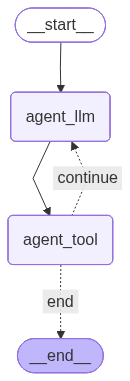

In [7]:
# Cell 7: Build and compile the LangGraph

graph = StateGraph(AgentState)

graph.add_node("agent_llm", agent_llm_node)
graph.add_node("agent_tool", agent_tool_node)

graph.set_entry_point("agent_llm")

# LLM -> TOOL
graph.add_edge("agent_llm", "agent_tool")

# TOOL -> LLM (loop) or END
graph.add_conditional_edges(
    "agent_tool",
    continue_or_end,
    {
        "continue": "agent_llm",
        "end": END,
    },
)

app = graph.compile()
app


In [8]:
# Cell 8: Run exploration with LangGraph

initial_state: AgentState = {
    "messages": [
        SystemMessage(content=system_prompt),
        HumanMessage(content="Begin by calling list_summary_files to see which summaries exist."),
    ],
    "step": 0,
    "tool_name": None,
    "tool_args": {},
}

final_state = app.invoke(initial_state)

exploration_messages: List[BaseMessage] = final_state["messages"]
len(exploration_messages)



=== LLM NODE (step=0) ===
AI raw: ```python
{"tool_name": "list_summary_files", "tool_args": {}}
```

This will return a list of summary filenames (ending in .summary.json) in the 'summaries/' directory. 

=== TOOL NODE (step=0) ===
Calling tool: list_summary_files with args: {}
Tool list_summary_files result (truncated): ['Export-of-Rice-Varieties-to-Bangladesh,-2018-19-to-2024-25.summary.json', 'All-India-Estimates-of-Area,-Production-&-Yield-of-Food-Grains.summary.json', 'All-India-profile_-Crop-wise-Area.summary.json'] 

=== LLM NODE (step=1) ===
AI raw: ```python
{"tool_name": "python_sandbox", "tool_args": "import json; summaries = json.loads(read_summary_file('Export-of-Rice-Varieties-to-Bangladesh,-2018-19-to-2024-25.summary.json')); print(summaries['dataset_name'])"}
``` 

=== TOOL NODE (step=1) ===
Calling tool: python_sandbox with args: import json; summaries = json.loads(read_summary_file('Export-of-Rice-Varieties-to-Bangladesh,-2018-19-to-2024-25.summary.json')); print(su

22

In [9]:
# Cell 9: Strict JSON parser for final proposals

import json

def parse_proposals_json(raw: str) -> Dict[str, Any]:
    """
    Extract a strict JSON object with top-level key 'proposals' from the model output.

    Tolerates:
    - plain JSON
    - JSON inside ``` ``` fences
    - extra explanation text before/after
    """
    raw = raw.strip()

    # 1) If there is a code fence ```...```, try to isolate content inside it
    if "```" in raw:
        first = raw.find("```")
        second = raw.find("```", first + 3)
        if second != -1:
            block = raw[first + 3 : second].strip()
            # Drop language tag like 'json' or 'python' on the first line
            first_line, *rest = block.split("\n", 1)
            if first_line.strip().lower() in ("json", "python") and rest:
                block = rest[0].strip()
            raw_candidate = block
        else:
            raw_candidate = raw
    else:
        raw_candidate = raw

    # 2) Try direct json.loads on the candidate
    try:
        obj = json.loads(raw_candidate)
        if isinstance(obj, dict) and "proposals" in obj:
            return obj
    except Exception:
        pass

    # 3) Fallback: grab from first '{' to last '}' and json.loads that
    start = raw_candidate.find("{")
    end = raw_candidate.rfind("}")
    if start != -1 and end != -1 and end > start:
        snippet = raw_candidate[start : end + 1]
        obj = json.loads(snippet)
        if isinstance(obj, dict) and "proposals" in obj:
            return obj

    raise ValueError("Could not parse proposals JSON from model output.")


In [10]:
# Cell 10: Build proposals from history (using exploration_messages)

def build_proposals_from_history(messages: List[BaseMessage]):
    """
    Ask the LLM (once, with at most 1 self-repair) to synthesize final TaskProposals
    as STRICT JSON. Parse, validate, and save as JSON.

    Returns:
        proposals_dict (raw JSON dict),
        stage2_output (Pydantic),
        out_path (Path to task_proposals.json).
    """
    final_prompt = """
Now, based on all the dataset summaries and tool outputs in this conversation,
synthesize your final plan of analytic tasks.

You MUST output a SINGLE STRICT JSON object with the following structure:

{
  "proposals": [
    {
      "id": "TSK-001",
      "category": "predictive" | "descriptive" | "unsupervised",
      "title": "short human-readable title",
      "problem_statement": "2–5 sentences explaining the analytic question and why it matters.",
      "required_files": ["Export-of-Rice-Varieties-to-Bangladesh,-2018-19-to-2024-25.csv", "..."],
      "join_plan": {
        "hypothesized_keys": [
          ["state", "year"],
          ["state", "crop", "year"]
        ],
        "notes": "brief commentary about join logic"
      },
      "target": {
        "name": "column name or null",
        "granularity": ["columns that define a prediction unit"] or null,
        "horizon": "forecast horizon like '1-year ahead' or null"
      },
      "feature_plan": {
        "candidates": ["Area-*", "Production-*", "..."],
        "transform_ideas": ["lagged features", "growth rates", "..."],
        "handling_missingness": "brief strategy"
      },
      "validation_plan": "how to evaluate or sanity-check this task",
      "quality_checks": [
        "simple checks to avoid leakage or broken joins",
        "..."
      ],
      "expected_outputs": [
        "tables",
        "plots",
        "model_metrics",
        "cluster_assignments",
        "summary_report"
      ]
    }
    // 2–7 more proposals here
  ]
}

STRICT JSON REQUIREMENTS:
- Use double quotes for all keys and string values.
- Use true / false / null for booleans and missing values.
- No comments, no trailing commas, no Python None/True/False.
- The top-level object MUST have exactly one key: "proposals".

Do NOT wrap your answer in natural language. It is OK (but not required) to wrap
your JSON in ```json ... ``` fences; if you do, the content inside MUST still be
valid JSON.
"""

    # First attempt
    all_messages = messages + [HumanMessage(content=final_prompt)]
    ai_final: AIMessage = llm.invoke(all_messages)

    raw = ai_final.content.strip()
    print("FINAL RAW (1st attempt):", raw[:400], "..." if len(raw) > 400 else "")

    try:
        proposals_dict = parse_proposals_json(raw)
    except Exception as e:
        print("[WARN] First JSON parse failed:", e)

        # Second attempt: ask the model explicitly to fix JSON
        repair_prompt = f"""
You previously tried to output JSON but it was not strictly valid.

Here is what you produced:

<<<
{raw}
>>>

Now, rewrite this into STRICT VALID JSON with the SAME intended content and the SAME "proposals" structure.

Requirements:
- A single JSON object with key "proposals".
- All keys and string values in double quotes.
- true / false / null instead of Python booleans or None.
- No comments, no trailing commas, no extra keys at top level.

Output ONLY the JSON (optionally inside ```json ... ```), with no extra explanation.
"""
        repair_messages = all_messages + [HumanMessage(content=repair_prompt)]
        ai_repair: AIMessage = llm.invoke(repair_messages)
        raw2 = ai_repair.content.strip()
        print("FINAL RAW (repair):", raw2[:400], "..." if len(raw2) > 400 else "")

        proposals_dict = parse_proposals_json(raw2)

    # Validate with Pydantic
    stage2_output = Stage2Output.model_validate(proposals_dict)

    # Save as JSON
    out_path = STAGE2_OUT_DIR / "task_proposals.json"
    out_path.write_text(json.dumps(proposals_dict, indent=2))

    return proposals_dict, stage2_output, out_path


In [11]:
# Cell 11: Run final synthesis

proposals_dict, stage2_output, proposals_path = build_proposals_from_history(exploration_messages)

print("\nSaved proposals to:", proposals_path)
print("Number of proposals:", len(stage2_output.proposals))
for p in stage2_output.proposals:
    print(f"- {p.id}: [{p.category}] {p.title}")


FINAL RAW (1st attempt): ```json
{
  "proposals": [
    {
      "id": "TSK-001",
      "category": "predictive",
      "title": "Rice Export Forecasting",
      "problem_statement": "Develop a model to forecast rice export quantities to Bangladesh based on historical data. This will help policymakers and traders make informed decisions. The model should account for seasonal fluctuations and trends in export quantities.",
 ...

Saved proposals to: /scratch/ziv_baretto/llmserve/stage2_out/task_proposals.json
Number of proposals: 2
- TSK-001: [predictive] Rice Export Forecasting
- TSK-002: [descriptive] Crop-wise Area Analysis
